# Examles of error propigation
Examples are taken from http://ipl.physics.harvard.edu/wp-uploads/2013/03/PS3_Error_Propagation_sp13.pdf and used on MCMC to show how the answers work

## Example 1

Example: suppose you measure the height H of a door and get 2.00 ± 0.03 m. This means that
H = 2.00 m and δH = 0.03 m. The door has a knob which is a height h = 0.88 ± 0.04 m from the bottom
of the door. Then the distance from the doorknob to the top of the door is Q = H − h = 1.12 m. What
is the uncertainty in Q?

Q = 1.12 ± 0.05 m


In [1]:
import numpy as np
import pymc3 as mc

This version uses prior distributions to do all the work. H and h are both informative priors that then drive the solution to the right answer. 

In [5]:
model = mc.Model()

with model:

    H = mc.Normal('H', 2.00, tau=(0.03)**-2)
    h = mc.Normal('h', 0.88, tau=(0.04)**-2)
    Q = mc.Deterministic('Q', H-h)
    trace = mc.sample(10000)

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, H]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5637.61draws/s]


In [18]:
mc.summary(trace)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
H,1.999911,0.029874,0.000149,1.941453,2.058027,42153.359123,0.999998
h,0.880060,0.040359,0.000195,0.802077,0.960552,40674.274410,1.000006
Q,1.119851,0.050118,0.000258,1.022845,1.219476,41081.677707,0.999993


MCMC gives 1.12 +/- 0.05, analytic gives 1.12 +/- 0.05


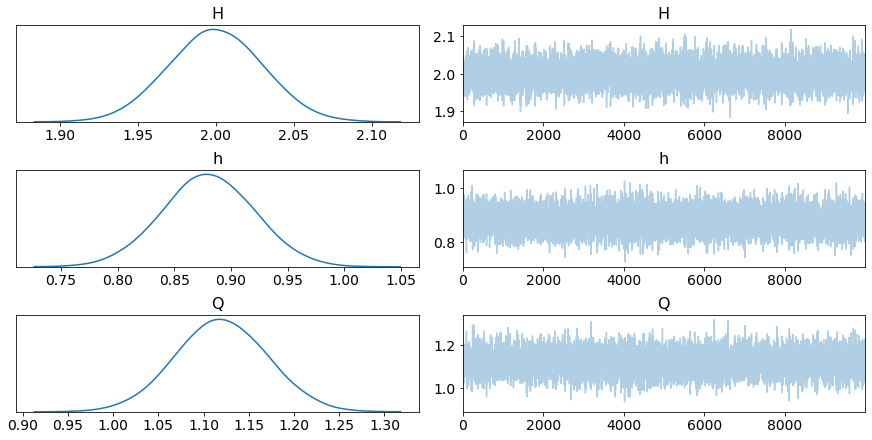

In [19]:
mc.traceplot(trace, combined=True)
print("MCMC gives {:.2f} +/- {:.2f}, analytic gives {} +/- {}".format(trace['Q'].mean(), 
                                                                          trace['Q'].std(), 1.12, 0.05))

This version uses uninformative priors and data to drive the solution to the right answer. 

In [22]:
model = mc.Model()

with model:
    H_mean = mc.Flat('H_mean')
    h_mean = mc.Flat('h_mean')
    
    H = mc.Normal('H', H_mean, 0.03, observed=[2.0])
    h = mc.Normal('h', h_mean, 0.04, observed=[0.88])
    Q = mc.Deterministic('Q', H-h)
    trace = mc.sample(10000)

    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h_mean, H_mean]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5148.17draws/s]


In [23]:
mc.summary(trace)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
H_mean,1.999911,2.972024e-02,1.493653e-04,1.941669,2.057941,40695.691383,0.999994
h_mean,0.879441,4.017716e-02,1.797034e-04,0.801734,0.958716,42258.706529,1.000005
Q__0,1.120000,4.440892e-16,4.440892e-17,1.120000,1.120000,2.000300,0.999950


MCMC gives 1.12 +/- 0.00, analytic gives 1.12 +/- 0.05


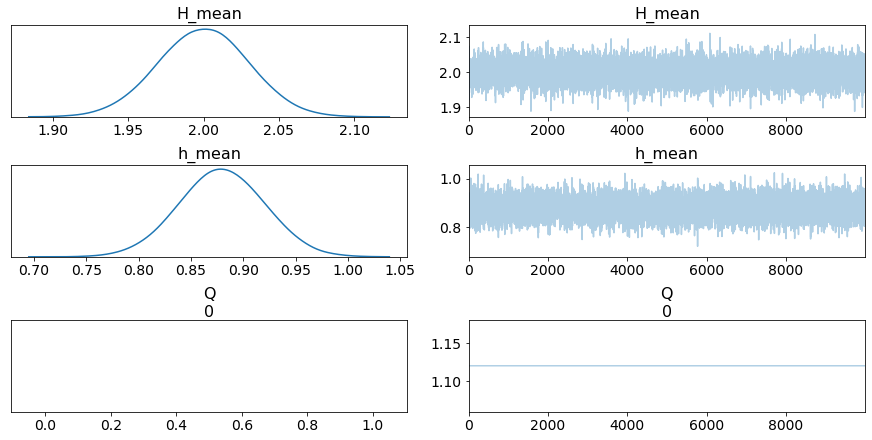

In [24]:
mc.traceplot(trace, combined=True)
print("MCMC gives {:.2f} +/- {:.2f}, analytic gives {} +/- {}".format(trace['Q'].mean(), 
                                                                          trace['Q'].std(), 1.12, 0.05))

## Example 2

Example: a bird flies a distance d = 120 ± 3 m during a time t = 20.0 ± 1.2 s. The average speed of
the bird is v = d/t = 6 m/s. What is the uncertainty of v?

0.39 m/s.

In [ ]:
with mc.Model() as model:
    d = mc.Normal('d', 123, tau=(3)**-2)
    t = mc.Normal('t', 20.0, tau=(1.2)**-2)
    v = mc.Deterministic('v', d/t)
    start = mc.find_MAP()
    trace = mc.sample(40000, njobs=4, start=start)

In [ ]:
mc.summary(trace)
mc.traceplot(trace, combined=True, lines={'d':123, 't':20, 'v':6})
print("MCMC gives {0:.2f}, analytic gives {1}".format(trace['v'].std(), 0.39))

## Example 3

Example: the period of an oscillation is measured to be T = 0.20 ± 0.01 s. Thus the frequency is
f = 1/T = 5 Hz. What is the uncertainty in f? Answer: the percent uncertainty in T was 0.01/0.20 = 5%.
Thus the percent uncertainty in f is also 5%, which means that δf = 0.25 Hz. So f = 5.0 ± 0.3 Hz (after
rounding).

f = 5.0 ± 0.3 Hz

In [ ]:
with mc.Model() as model:
    T = mc.Normal('T', 0.20, tau=(0.01)**-2)

    mc.Deterministic('1/T', 1/T)
    start = mc.find_MAP()

    trace = mc.sample(1e4, burn=100, burn_till_tuned=True, start=start)


In [ ]:
mc.traceplot(trace, combined=True)

In [ ]:
print(mc.summary(trace))
print("MCMC gives {0:.1f} +/- {1:.1f}, analytic gives {2} +/- {3}".format(np.mean(trace['1/T']), 
                                                                          np.std(trace['1/T']), 
                                                                          5.0, 0.3))


## Example 4

Example: a ball is tossed straight up into the air with initial speed v0 = 4.0 ± 0.2 m/s. After a time
t = 0.60±0.06 s, the height of the ball is y = v0t−
1
2
gt2 = 0.636 m. What is the uncertainty of y? Assume
g = 9.80 m/s2
(no uncertainty in g).

Thus y would be properly reported as 0.6 ± 0.4 m.

In [ ]:
with mc.Model() as model:
    g = 9.80
    t = mc.Normal('t', 0.60, tau=(0.06)**-2)
    v0 = mc.Normal('v0', 4.0, tau=(0.2)**-2)

    h = mc.Deterministic('h', v0*t - 0.5*g*t**2)
    start = mc.find_MAP()

    trace = mc.sample(1e4, burn=100, burn_till_tuned=True, start=start)



In [ ]:
mc.traceplot(trace, combined=True)

In [ ]:
print(mc.summary(trace))
print("MCMC gives {0:.1f} +/- {1:.1f}, analytic gives {2} +/- {3}".format(np.mean(trace['h']), 
                                                                          np.std(trace['h']), 
                                                                          0.6, 0.4))


## Example 5
For example, suppose Ann and Billy both measure the speed of a moving ball. Ann measures 3.6±0.2 m/s
and Billy gets 3.3 ± 0.3 m/s. Do the two measurements agree?

D = 0.3 ± 0.4 m/s  so 0 is in the range, they do agree.

In [ ]:
with mc.Model() as model:

    A = mc.Normal('A', 3.6, tau=(0.2)**-2)
    B = mc.Normal('B', 3.3, tau=(0.3)**-2)

    D = mc.Deterministic('D', A-B)
    start = mc.find_MAP()

    trace = mc.sample(1e4, burn=100, burn_till_tuned=True, start=start)



In [ ]:
mc.traceplot(trace, combined=True);

In [ ]:
print(mc.summary(trace))
print("MCMC gives {0:.1f} +/- {1:.1f}, analytic gives {2} +/- {3}".format(np.mean(trace['D']), 
                                                                          np.std(trace['D']), 
                                                                          0.3, 0.4))
# mc.Matplot.plot(model)